Preprocessing from:
https://github.com/gsurma/histopathologic_cancer_detector/blob/master/histopathologic_cancer_detector.ipynb
<br>Model from:
https://www.kaggle.com/fmarazzi/baseline-keras-cnn-roc-fast-10min-0-925-lb

-----------------------------------------
# Data visualization

In [1]:
%matplotlib inline

import numpy as np 
import pandas as pd 
from glob import glob 
from skimage.io import imread 
import os
import shutil
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
# from keras.applications.nasnet import NASNetMobile
# from keras.applications import NASNetMobile
# from keras.applications.xception import Xception
from keras.utils.vis_utils import plot_model
from keras.layers import Dropout, Flatten, Dense, GlobalAveragePooling2D, Average
from keras.layers import Input, Concatenate, GlobalMaxPooling2D, BatchNormalization
from keras.layers import Conv2D, MaxPool2D, Activation
from keras.models import Model
from keras.models import Sequential
from keras.callbacks import CSVLogger, ModelCheckpoint
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras.optimizers import RMSprop, Adam
from keras.models import load_model
# from livelossplot import PlotLossesKeras

# import src.constants

Using TensorFlow backend.


In [2]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 6514992674575883642
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 15077804774555148538
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 7472622333732507599
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 7390353818
locality {
  bus_id: 1
  links {
  }
}
incarnation: 4246047789013381386
physical_device_desc: "device: 0, name: Tesla P4, pci bus id: 0000:00:04.0, compute capability: 6.1"
]


In [3]:
# Output files
OUTPUT_DIR = "output_model2/"
# MODEL_SUMMARY_FILE = OUTPUT_DIR + "model_summary.txt"
MODEL_PLOT_FILE = OUTPUT_DIR + "model_plot.png"

TRAINING_LOGS_FILE_1 = OUTPUT_DIR + "training_logs_no_aug.csv"
MODEL_FILE_1 = OUTPUT_DIR + "model_no_aug.h5"
TRAINING_PLOT_FILE_1 = OUTPUT_DIR + "training_no_aug.png"
VALIDATION_PLOT_FILE_1 = OUTPUT_DIR + "validation_no_aug.png"
ROC_PLOT_FILE_1 = OUTPUT_DIR + "roc_no_aug.png"

TRAINING_LOGS_FILE_2 = OUTPUT_DIR + "training_logs_aug.csv"
MODEL_FILE_2 = OUTPUT_DIR + "model_aug.h5"
TRAINING_PLOT_FILE_2 = OUTPUT_DIR + "training_aug.png"
VALIDATION_PLOT_FILE_2 = OUTPUT_DIR + "validation_aug.png"
ROC_PLOT_FILE_2 = OUTPUT_DIR + "roc_aug.png"

KAGGLE_SUBMISSION_FILE_1 = OUTPUT_DIR + "kaggle_submission_no_aug.csv"
KAGGLE_SUBMISSION_FILE_2 = OUTPUT_DIR + "kaggle_submission_aug.csv"

# Hyperparams
SAMPLE_COUNT = 85000 #??? why only 85000
TRAINING_RATIO = 0.9
IMAGE_SIZE = 96
EPOCHS = 1
BATCH_SIZE = 192
VERBOSITY = 1
TESTING_BATCH_SIZE = 5000

In [4]:
# Data (https://www.kaggle.com/c/histopathologic-cancer-detection/data)
#input_dir = '../input/'
def prepare_data_for_augmentation(need_to_prepare = False):
    training_path = 'data/training'
    validation_path = 'data/validation'
    if (need_to_prepare == True):
        data_dir = 'data/'
        training_dir = data_dir + 'train/'
        data_frame = pd.DataFrame({'path': glob(os.path.join(training_dir,'*.tif'))})
        data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[2].split('.')[0])
        labels = pd.read_csv(data_dir + 'train_labels.csv')
        data_frame = data_frame.merge(labels, on='id')
        negatives = data_frame[data_frame.label == 0].sample(SAMPLE_COUNT)
        positives = data_frame[data_frame.label == 1].sample(SAMPLE_COUNT)
        data_frame = pd.concat([negatives, positives]).reset_index()
        data_frame = data_frame[['path', 'id', 'label']]
        data_frame['image'] = data_frame['path'].map(imread)

        training_path = 'data/training'
        validation_path = 'data/validation'

        for folder in [training_path, validation_path]:
            for subfolder in ['0', '1']:
                path = os.path.join(folder, subfolder)
                os.makedirs(path, exist_ok=True)

        training, validation = train_test_split(data_frame, train_size=TRAINING_RATIO, stratify=data_frame['label'])

        data_frame.set_index('id', inplace=True)

        for images_and_path in [(training, training_path), (validation, validation_path)]:
            images = images_and_path[0]
            path = images_and_path[1]
            for image in images['id'].values:
                file_name = image + '.tif'
                label = str(data_frame.loc[image,'label'])
                destination = os.path.join(path, label, file_name)
                if not os.path.exists(destination):
                    source = os.path.join(data_dir + 'train', file_name)
                    shutil.copyfile(source, destination)
    
    return [training_path, validation_path]

In [5]:
def prepare_data_generator(with_augmentation, training_path, validation_path):
    if (with_augmentation == True):
        # Data augmentation
        training_data_generator = ImageDataGenerator(
            rescale=1./255,
            horizontal_flip=True,
            vertical_flip=True,
            rotation_range=180,
            zoom_range=0.4, 
            width_shift_range=0.3,
            height_shift_range=0.3,
            shear_range=0.3,
            channel_shift_range=0.3)
    else:
        # just rescale it now
        training_data_generator = ImageDataGenerator(rescale=1./255)

    # Data generation
    training_generator = training_data_generator.flow_from_directory(
        training_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary')

    validation_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        validation_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary')

    testing_generator = ImageDataGenerator(rescale=1./255).flow_from_directory(
        validation_path,
        target_size=(IMAGE_SIZE,IMAGE_SIZE),
        batch_size=BATCH_SIZE,
        class_mode='binary',
        shuffle=False)
    
    return [training_generator, validation_generator, testing_generator]


In [6]:
# Model
def create_model(file = ''):
    kernel_size = (3,3)
    pool_size= (2,2)
    first_filters = 32
    second_filters = 64
    third_filters = 128

    dropout_conv = 0.3
    dropout_dense = 0.5

    model = Sequential()
    model.add(Conv2D(first_filters, kernel_size, activation = 'relu', input_shape = (IMAGE_SIZE, IMAGE_SIZE, 3)))
    model.add(Conv2D(first_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size)) 
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(second_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Conv2D(third_filters, kernel_size, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(MaxPool2D(pool_size = pool_size))
    model.add(Dropout(dropout_conv))

    #model.add(GlobalAveragePooling2D())
    model.add(Flatten())
    model.add(Dense(256, use_bias=False))
    model.add(BatchNormalization())
    model.add(Activation("relu"))
    model.add(Dropout(dropout_dense))
    model.add(Dense(1, activation = "sigmoid"))
    
    if (os.path.exists(file) == True):
        model = load_model(file)

    # Compile the model
    model.compile(Adam(0.01), loss = "binary_crossentropy", metrics=["accuracy"])
    model.summary()

    plot_model(model,
               to_file=MODEL_PLOT_FILE,
               show_shapes=True,
               show_layer_names=True)
    
    return model

In [7]:
def train(model, training_generator, validation_generator, model_file, logs_file):
    #  Training
#     earlystopper = EarlyStopping(monitor='val_loss', patience=2, verbose=1, restore_best_weights=True)
#     reducel = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.1)
    history = model.fit_generator(training_generator, 
                                    steps_per_epoch=len(training_generator), 
                                    validation_data=validation_generator,
                                    validation_steps=len(validation_generator),
                                    epochs=EPOCHS,
                                    callbacks=[ModelCheckpoint(model_file,
                                                             monitor='val_acc',
                                                             verbose=VERBOSITY,
                                                             save_best_only=True,
                                                             mode='max'),
                                                 CSVLogger(logs_file,
                                                           append=False,
                                                           separator=';')])
#     PlotLossesKeras(),


#     history = model.fit_generator(training_generator,
#                                   steps_per_epoch=len(training_generator), 
#                                   validation_data=validation_generator,
#                                   validation_steps=len(validation_generator),
#                                   epochs=EPOCHS,
#                                   verbose=0,
#                                   callbacks=[PlotLossesKeras(),
#                                              ModelCheckpoint(MODEL_FILE,
#                                                              monitor='val_acc',
#                                                              verbose=VERBOSITY,
#                                                              save_best_only=True,
#                                                              mode='max'),
#                                              CSVLogger(TRAINING_LOGS_FILE,
#                                                        append=False,
#                                                        separator=';')])

In [8]:
def plot_epochs(history, training_plot_file, validation_plot_file):
    # Training plots
    epochs = [i for i in range(1, len(history.history['loss'])+1)]

    plt.plot(epochs, history.history['loss'], color='blue', label="training_loss")
    plt.plot(epochs, history.history['val_loss'], color='red', label="validation_loss")
    plt.legend(loc='best')
    plt.title('training')
    plt.xlabel('epoch')
    plt.savefig(training_plot_file, bbox_inches='tight')
    plt.close()

    plt.plot(epochs, history.history['acc'], color='blue', label="training_accuracy")
    plt.plot(epochs, history.history['val_acc'], color='red',label="validation_accuracy")
    plt.legend(loc='best')
    plt.title('validation')
    plt.xlabel('epoch')
    plt.savefig(validation_plot_file, bbox_inches='tight')
    plt.close()

In [9]:
def plot_AUC(model, testing_generator, model_file, plot_file):
    # ROC testing plot
    model.load_weights(model_file)
    predictions = model.predict_generator(testing_generator, steps=len(testing_generator), verbose=VERBOSITY)
    false_positive_rate, true_positive_rate, threshold = roc_curve(testing_generator.classes, predictions)
    area_under_curve = auc(false_positive_rate, true_positive_rate)
    
    print("False positive: ", false_positive_rate)
    print("True positive: ", true_positive_rate)

    plt.plot([0, 1], [0, 1], 'k--')
    plt.plot(false_positive_rate, true_positive_rate, label='AUC = {:.3f}'.format(area_under_curve))
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')
    plt.title('ROC curve')
    plt.legend(loc='best')
    plt.show()
    plt.savefig(plot_file, bbox_inches='tight')
    plt.close()


In [10]:
def test(model, file):
    testing_files = glob(os.path.join('data/test/','*.tif'))
    submission = pd.DataFrame()
    for index in range(0, len(testing_files), TESTING_BATCH_SIZE):
        data_frame = pd.DataFrame({'path': testing_files[index:index+TESTING_BATCH_SIZE]})
        data_frame['id'] = data_frame.path.map(lambda x: x.split('/')[2].split(".")[0])
        data_frame['image'] = data_frame['path'].map(imread)
        images = np.stack(data_frame.image, axis=0)
        predicted_labels = [model.predict(np.expand_dims(image/255.0, axis=0))[0][0] for image in images]
        predictions = np.array(predicted_labels)
        data_frame['label'] = predictions
        submission = pd.concat([submission, data_frame[["id", "label"]]])
    submission.to_csv(file, index=False, header=True)

In [11]:
#run without augmentation
paths = prepare_data_for_augmentation(need_to_prepare=False)

In [12]:
generators = prepare_data_generator(
    with_augmentation = False, 
    training_path = paths[0], 
    validation_path = paths[1])

Found 195526 images belonging to 2 classes.
Found 32606 images belonging to 2 classes.
Found 32606 images belonging to 2 classes.


In [13]:
model = create_model(MODEL_FILE_1)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_1 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_1 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 46, 46, 32)        0         
_______________________________________

In [16]:
history = train(model = model, 
                training_generator = generators[0],
                validation_generator = generators[1],
                model_file = MODEL_FILE_1,
                logs_file = TRAINING_LOGS_FILE_1)

Epoch 1/1
1019/1019 [==============================] - 1360s 1s/step - loss: 0.1284 - acc: 0.9526 - val_loss: 0.4584 - val_acc: 0.8310

Epoch 00001: val_acc improved from -inf to 0.83095, saving model to output_model2/model_no_aug.h5


170/170 [==============================] - 18s 108ms/step
False positive:  [0.         0.         0.         ... 0.99707976 0.99811401 1.        ]
True positive:  [0.         0.01360628 0.01564723 ... 1.         1.         1.        ]


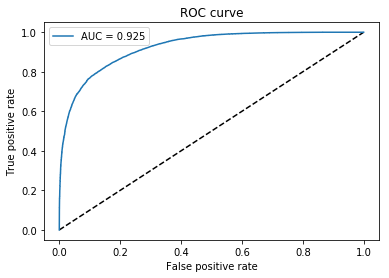

In [17]:
# plot_epochs(history, TRAINING_PLOT_FILE_1, VALIDATION_PLOT_FILE_1)
plot_AUC(model, generators[2], MODEL_FILE_1, ROC_PLOT_FILE_1)

In [ ]:
# test(model = model, file = KAGGLE_SUBMISSION_FILE_1)

In [14]:
generators = prepare_data_generator(
    with_augmentation = True, 
    training_path = paths[0], 
    validation_path = paths[1])

Found 195526 images belonging to 2 classes.
Found 32606 images belonging to 2 classes.
Found 32606 images belonging to 2 classes.


In [15]:
model_with_aug = create_model(MODEL_FILE_2)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_7 (Conv2D)            (None, 94, 94, 32)        896       
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 92, 92, 32)        9216      
_________________________________________________________________
batch_normalization_7 (Batch (None, 92, 92, 32)        128       
_________________________________________________________________
activation_7 (Activation)    (None, 92, 92, 32)        0         
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 46, 46, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 46, 46, 32)        0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 44, 44, 64)        18432     
__________

In [16]:
history = train(model = model_with_aug, 
                training_generator = generators[0],
                validation_generator = generators[1],
                model_file = MODEL_FILE_2,
                logs_file = TRAINING_LOGS_FILE_2)

Epoch 1/1
1019/1019 [==============================] - 624s 612ms/step - loss: 0.2437 - acc: 0.9029 - val_loss: 0.7875 - val_acc: 0.7484

Epoch 00001: val_acc improved from -inf to 0.74839, saving model to output_model2/model_aug.h5


170/170 [==============================] - 18s 109ms/step
False positive:  [0.         0.         0.         ... 0.97846322 0.98235688 1.        ]
True positive:  [0.00000000e+00 1.23693488e-04 1.85540231e-04 ... 1.00000000e+00
 1.00000000e+00 1.00000000e+00]


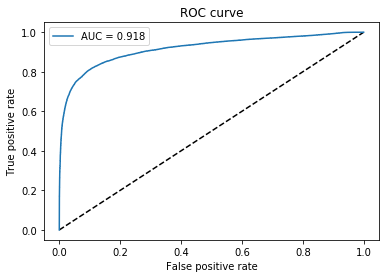

In [17]:
# plot_epochs(history, TRAINING_PLOT_FILE_2, VALIDATION_PLOT_FILE_2)
plot_AUC(model_with_aug, generators[2], MODEL_FILE_2, ROC_PLOT_FILE_2)

In [ ]:
test(model = model_with_aug, file = KAGGLE_SUBMISSION_FILE_2)